In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

In [2]:
import argparse
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path

LABEL_COLOR_MAP = {
    0: (0.0, 1.0, 1.0),   # Cyan
    1: (0.0, 1.0, 0.0),   # Green
    2: (1.0, 1.0, 0.0),   # Yellow
    3: (1.0, 0.0, 0.0),   # Red
    4: (1.0, 0.0, 1.0)    # Magenta
}

def load_labels(label_path):
    df = pd.read_csv(label_path, usecols=["start", "end", "label"])  
    df.label = df.label.astype(int)
    return df

def plot_waveform_with_boxes_fast(wav, label_path, sr=22050, max_points=2000):
    # Load audio
    duration = librosa.get_duration(y=wav, sr=sr)
    time = np.linspace(0, duration, len(wav))

    # Downsample for plotting
    if len(wav) > max_points:
        factor = len(wav) // max_points
        wav = wav[:factor * max_points].reshape(-1, factor).mean(axis=1)
        time = time[:factor * max_points].reshape(-1, factor).mean(axis=1)

    # Load labels
    label_df = load_labels(label_path)

    # Plot waveform
    plt.figure(figsize=(16, 4))
    plt.plot(time, wav, color="black", linewidth=0.5, alpha=0.6)

    # Plot label spans only (skip text for speed)
    for _, row in label_df.iterrows():
        start, end, label = row["start"], row["end"], row["label"]
        color = LABEL_COLOR_MAP.get(label, "gray")
        if end > time[0] and start < time[-1]:  # Only if label is in the visible range
            plt.axvspan(start, end, color=color, alpha=0.3)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Labeled Audio: {Path(label_path).stem}")
    plt.tight_layout()

    plt.show()

def plot_mel_spectrogram(wav, sr=22050, n_mels=128, hop_length=512):
    # Compute mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    # Plotting
    plt.figure(figsize=(16, 5))
    librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr, hop_length=hop_length, cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (dB)')
    plt.tight_layout()
    plt.show()

In [3]:
wv, sr = torchaudio.load("/Users/crinistad/work/data/final_train_data/SP_1.wav", channels_first=False)

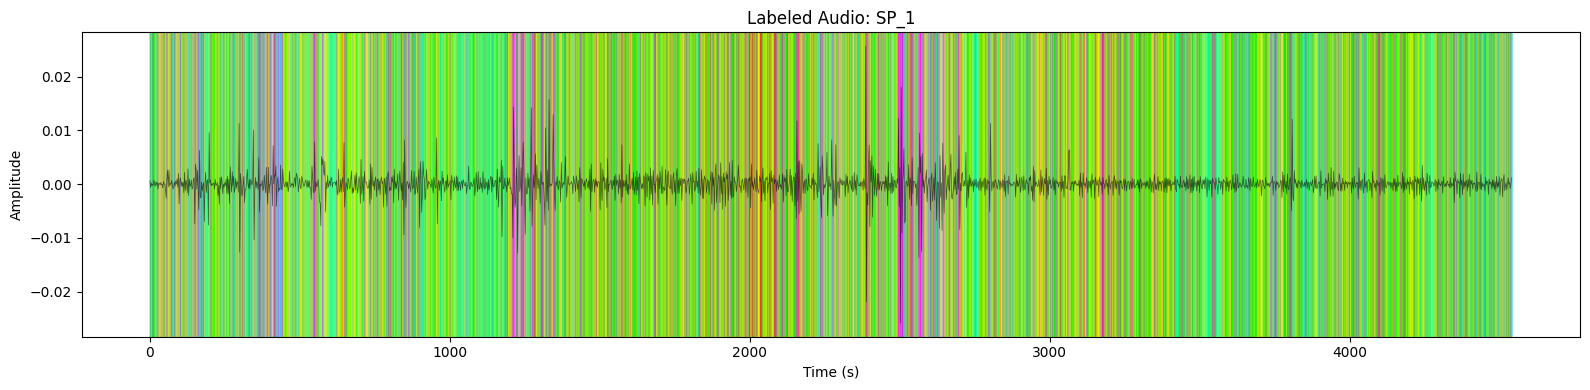

In [4]:
from pathlib import Path
plot_waveform_with_boxes_fast(wav=wv.squeeze(), sr=sr, label_path=Path("/Users/crinistad/work/data/final_train_data/SP_1.csv"))

In [5]:
wv.squeeze().shape

torch.Size([72650290])

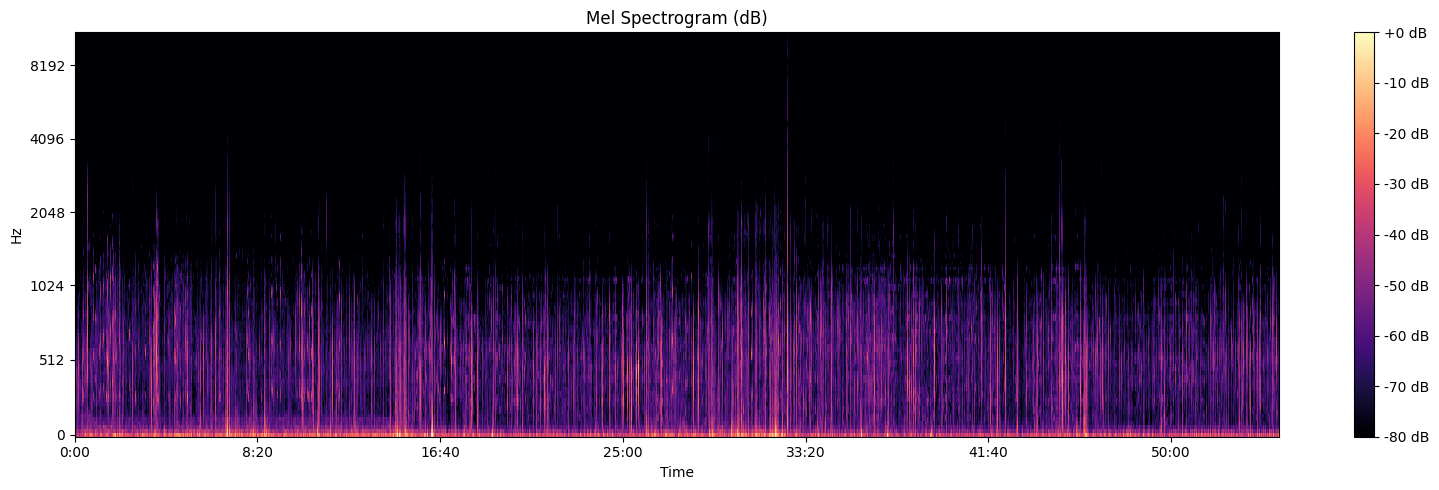

In [6]:
plot_mel_spectrogram(wv.squeeze().numpy())

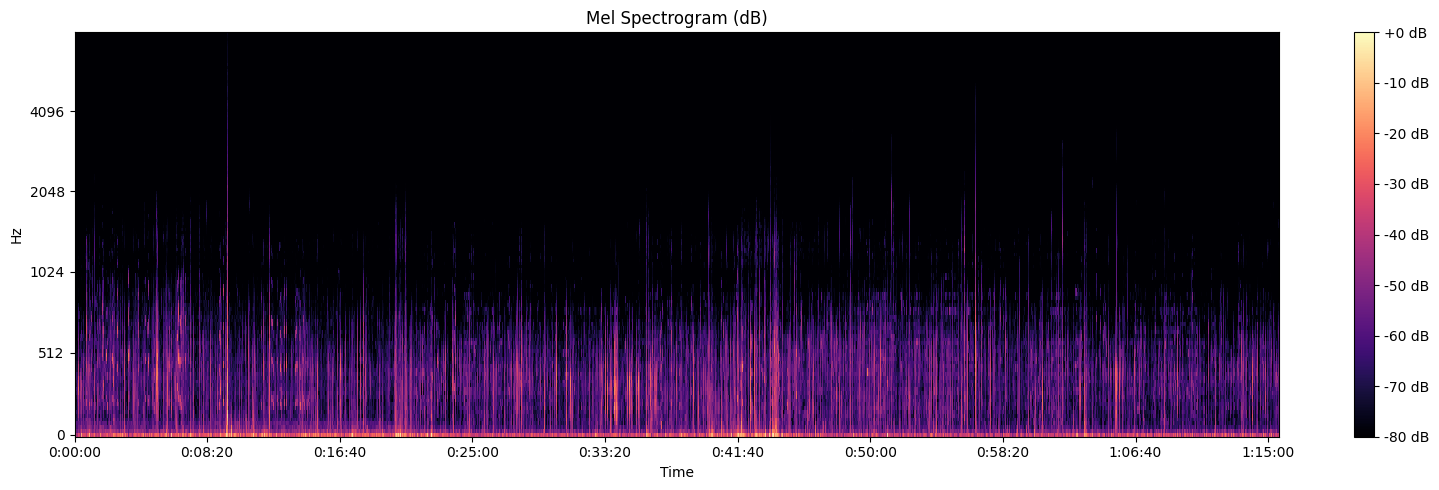

In [7]:
plot_mel_spectrogram(wv.squeeze().numpy(), sr)


In [4]:
def apply_codec(waveform, sample_rate, format, encoder=None):
    encoder = torchaudio.io.AudioEffector(format=format, encoder=encoder)
    return encoder.apply(waveform, sample_rate)

In [10]:
wv2 = apply_codec(wv, sr, format="wav", encoder="pcm_mulaw")

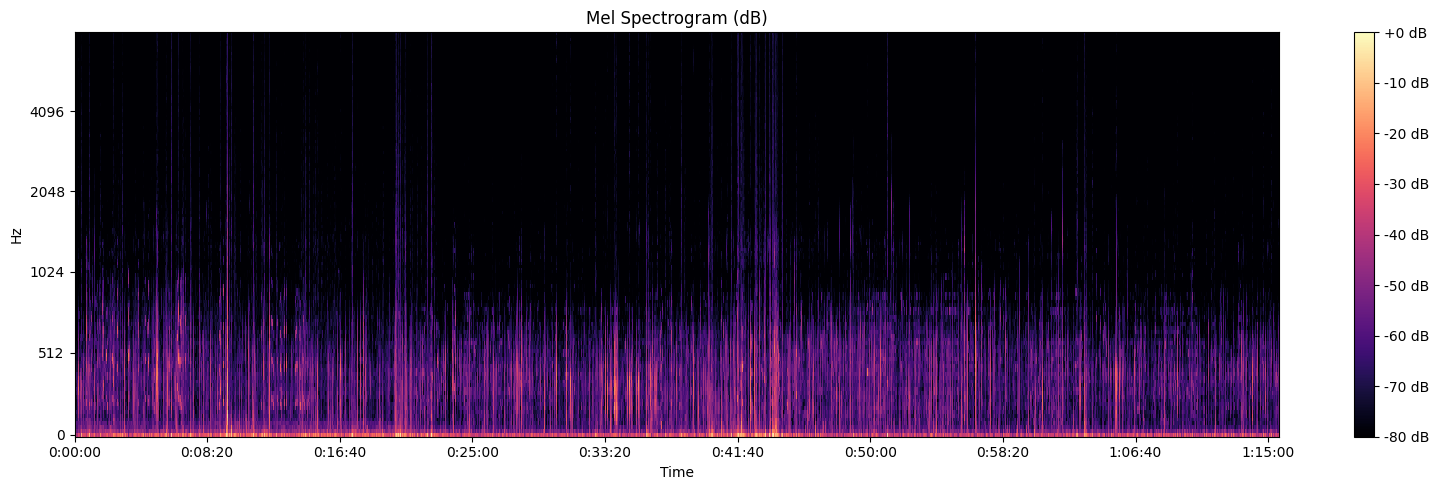

In [11]:
plot_mel_spectrogram(wv2.squeeze().numpy(), sr)

[W504 14:02:20.236322000 encode_process.cpp:173] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())


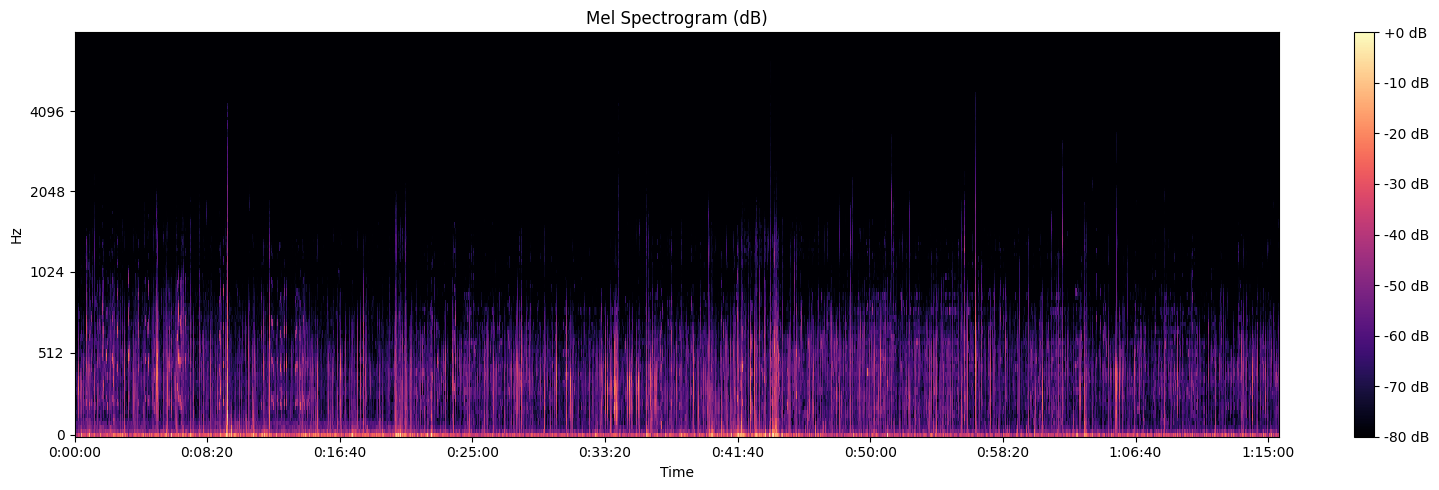

In [7]:
wv3 = apply_codec(wv, sr, "ogg", encoder="vorbis")
plot_mel_spectrogram(wv3.squeeze().numpy(), sr)

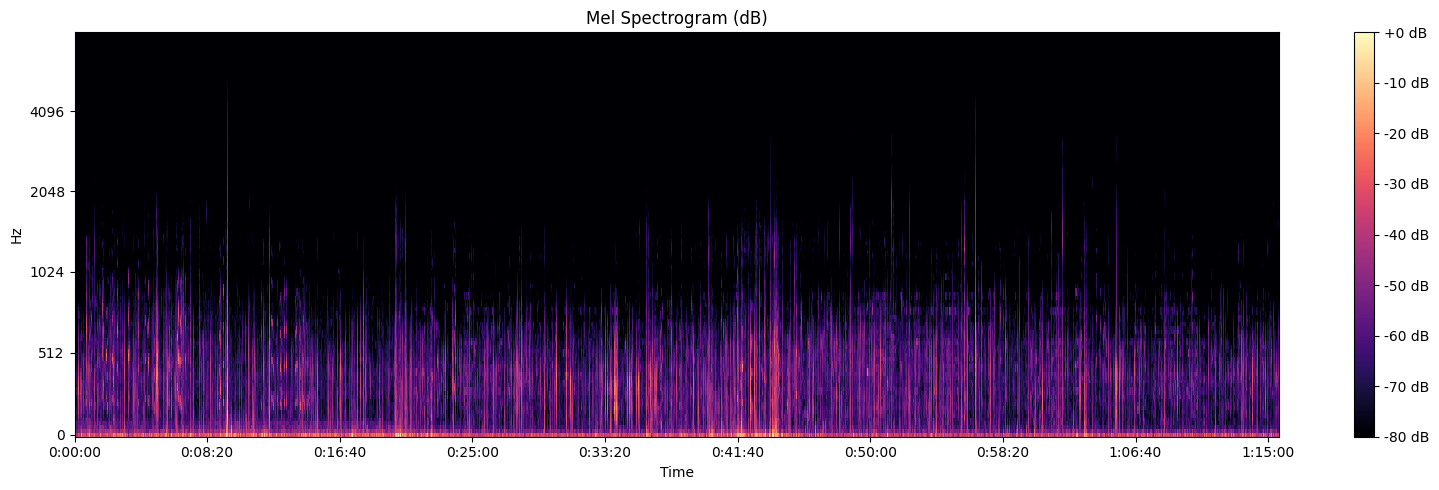

In [8]:
wv3 = apply_codec(wv, sr, "g722")
plot_mel_spectrogram(wv3.squeeze().numpy(), sr)

In [9]:
metadata = torchaudio.info("/Users/crinistad/work/data/final_train_data/SP_1.wav")
print(metadata)


AudioMetaData(sample_rate=16000, num_frames=72650290, num_channels=1, bits_per_sample=16, encoding=PCM_S)


In [10]:
def print_stats(waveform, sample_rate=None, src=None):
    if src:
        print("-" * 10)
    print("Source:", src)
    print("-" * 10)
    if sample_rate:
        print("Sample Rate:", sample_rate)
    print("Shape:", tuple(waveform.shape))
    print("Dtype:", waveform.dtype)
    print(f" - Max:     {waveform.max().item():6.3f}")
    print(f" - Min:     {waveform.min().item():6.3f}")
    print(f" - Mean:    {waveform.mean().item():6.3f}")
    print(f" - Std Dev: {waveform.std().item():6.3f}")
    print()
    print(waveform)
    print()

In [11]:
print_stats(wv, sr)

Source: None
----------
Sample Rate: 16000
Shape: (72650290, 1)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.099

tensor([[ 0.0096],
        [ 0.0100],
        [ 0.0104],
        ...,
        [-0.0242],
        [-0.0245],
        [-0.0249]])



In [14]:

def get_spectrogram(
    wv,
    n_fft=1024,
    win_len=None,
    hop_len=512,
    power=2.0,
):
    spectrogram = T.Spectrogram(
        n_fft=n_fft,
        win_length=win_len,
        hop_length=hop_len,
        center=True,
        pad_mode="reflect",
        power=power,
    )
    return spectrogram(wv)

In [24]:
wv.shape

torch.Size([72650290, 1])

In [25]:
spec = get_spectrogram(power=None, wv=wv.T)

In [26]:
spec.shape

torch.Size([1, 513, 141896])

In [27]:
stretch = T.TimeStretch(n_freq=spec.shape[1])

spec_12 = stretch(spec, overriding_rate=1.2)
spec_09 = stretch(spec, overriding_rate=0.9)

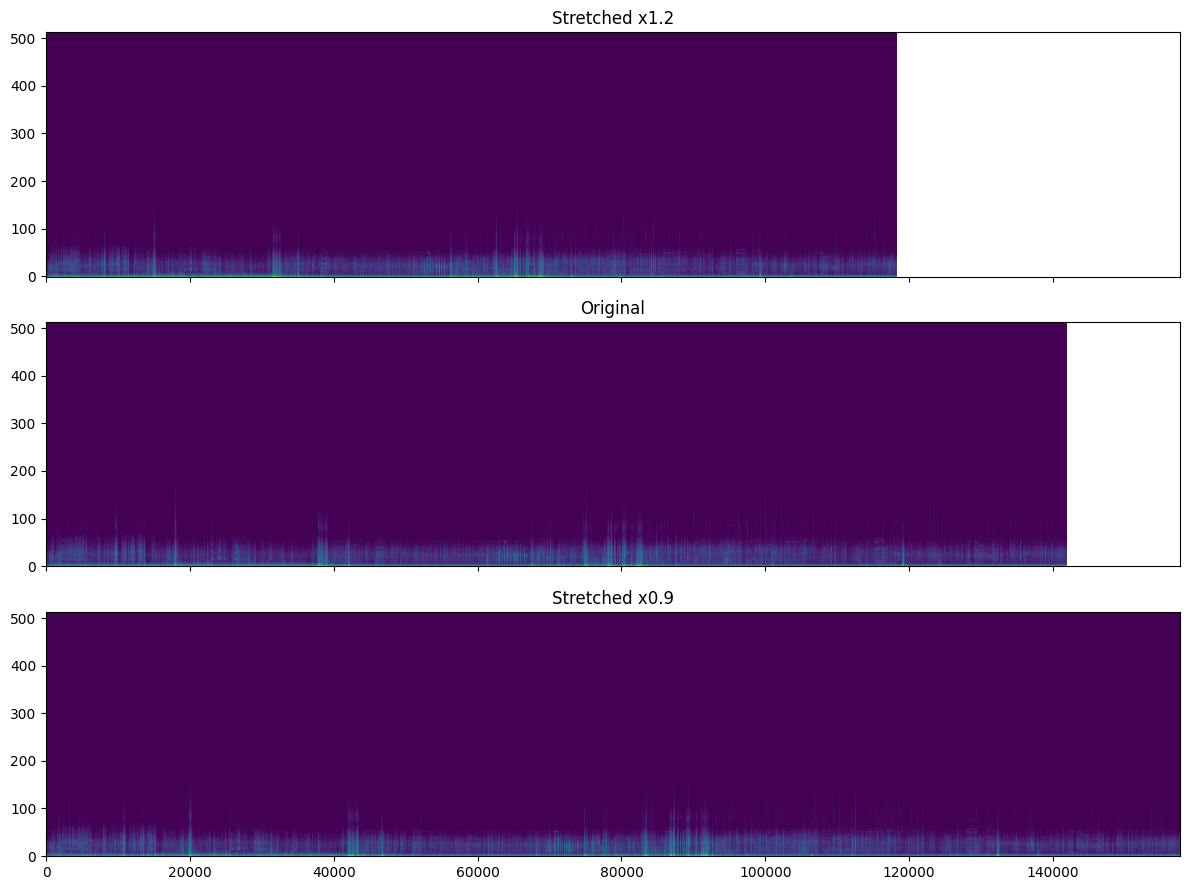

In [42]:
def plot():
    def plot_spec(ax, spec, title):
        ax.set_title(title)
        ax.imshow(librosa.amplitude_to_db(spec), origin="lower", aspect="auto")

    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True, sharey=True)
    plot_spec(axes[0], torch.abs(spec_12[0]), title="Stretched x1.2")
    plot_spec(axes[1], torch.abs(spec[0]), title="Original")
    plot_spec(axes[2], torch.abs(spec_09[0]), title="Stretched x0.9")
    fig.tight_layout()

plot()